In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores, find_all
import shap
shap.initjs()

In [2]:
def merge_strings_and_integers(val):
    try:
        return int(val)
    except:
        return 'other'

In [3]:
df = pd.read_csv("final_autof.csv")
df.drop(['MODE(consumptions.MS_METER_NBR)',
                #'MODE(consumptions.DAY(MEASUREMENT_DATE))',
         #'MODE(consumptions.MONTH(MEASUREMENT_DATE))',
                #'MODE(consumptions.WEEKDAY(MEASUREMENT_DATE))',
                'MODE(representations.SUPPLIER)',
                'MODE(representations.SUPPLIER_TO)',
               #'MODE(representations.DAY(END_DATE))',
                #'MODE(representations.MONTH(END_DATE))',
                #'MODE(representations.WEEKDAY(END_DATE))',
                #'MODE(representations.YEAR(END_DATE))',
                #'MODE(requests.DAY(REQUEST_DATE))',
       #'MODE(requests.MONTH(REQUEST_DATE))',
       #'MODE(requests.WEEKDAY(REQUEST_DATE))',
       #'MODE(requests.YEAR(REQUEST_DATE))',
                #'MODE(consumptions.BS_RATE)',
                #'NUM_UNIQUE(representations.MONTH(END_DATE))',
                #'NUM_UNIQUE(representations.SUPPLIER)'
               ], axis=1, inplace=True)
df.dropna(subset=['number_of_zeros'], inplace=True)


df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(merge_strings_and_integers)
#transform_func = lambda x: x if x in [10, 11, 21] else 'other'
#df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(transform_func)
df = df.drop(['rec_id'], axis=1)
df = df.drop_duplicates()
df['MODE(requests.REQUEST_TYPE)'] = df['MODE(requests.REQUEST_TYPE)'].replace(0, 'unknown')
df = pd.get_dummies(df, columns=['MODE(requests.REQUEST_TYPE)'], prefix='MODE(requests.REQUEST_TYPE)')
df = pd.get_dummies(df, columns=['MODE(consumptions.BS_RATE)'], prefix='MODE(consumptions.BS_RATE)')
df = df.drop(['voltage'], axis=1)
df.fillna(0, inplace=True)
df.head()

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def train(clf, X, y, cols):
    #for clf_name, clf in clfs.items():
    # Initialize the evaluation metrics lists
    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores = []
    brier_scores, auc_roc_scores, pr_auc_scores = [], [], []
    lift_scores, demotion_scores, weighted_scores = [], [], []
    scaler = MinMaxScaler()
    print("Classifier: CATBOOST")
    assert len(X) == len(y)
    print("Number of samples:", len(X))
    print("Data bins", np.bincount(y))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        
        print("bins", np.bincount(y_train))
        print("bins", np.bincount(y_test))

        #if clf_name == "CatBoost":
        clf.fit(X_train, y_train, verbose=False)

        #else:
        #clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        acc, precision, recall, f1 = get_classification_metrics(y_test.values, y_pred)

        y_scores = clf.predict_proba(X_test)
        idx = np.argmax(y_scores, axis=1)
        y_scores = np.where(idx == 0, 1 - y_scores[:, 0], y_scores[:, 1])


        brier, roc_auc, pr_auc = get_probability_measures(y_test.values, y_scores)

        num_ones = np.sum(y_test == 1)


        s1 = int(0.1 * num_ones)
        s2 = int(0.2 * num_ones)
        s3 = int(0.3 * num_ones)
        s4 = int(0.4 * num_ones)
        s5 = int(0.5 * num_ones)
        s6 = int(0.6 * num_ones)
        s7 = int(0.7 * num_ones)
        s8 = int(0.8 * num_ones)
        s9 = int(0.9 * num_ones)
        s10 = int(1 * num_ones)

        lift1, demotion1, weighted_score1 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s1)
        lift2, demotion2, weighted_score2 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s2)
        lift3, demotion3, weighted_score3 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s3)
        lift4, demotion4, weighted_score4 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s4)
        lift5, demotion5, weighted_score5 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s5)
        lift6, demotion6, weighted_score6 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s6)
        lift7, demotion7, weighted_score7 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s7)
        lift8, demotion8, weighted_score8 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s8)
        lift9, demotion9, weighted_score9 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s9)
        lift10, demotion10, weighted_score10 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s10)

        acc_scores.append(acc)
        prec_scores.append(precision)
        rec_scores.append(recall)
        f1_scores.append(f1)

        brier_scores.append(brier)
        auc_roc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)

        lift_scores.append(lift4)
        demotion_scores.append(demotion4)
        weighted_scores.append(weighted_score4)

        print(f"0.1 -- Lift: {lift1:.4f}, Demotion: {demotion1:.4f}, Weighted: {weighted_score1:.4f}")
        print(f"0.2 -- Lift: {lift2:.4f}, Demotion: {demotion2:.4f}, Weighted: {weighted_score2:.4f}")
        print(f"0.3 -- Lift: {lift3:.4f}, Demotion: {demotion3:.4f}, Weighted: {weighted_score3:.4f}")
        print(f"0.4 -- Lift: {lift4:.4f}, Demotion: {demotion4:.4f}, Weighted: {weighted_score4:.4f}")
        print(f"0.5 -- Lift: {lift5:.4f}, Demotion: {demotion5:.4f}, Weighted: {weighted_score5:.4f}")
        print(f"0.6 -- Lift: {lift6:.4f}, Demotion: {demotion6:.4f}, Weighted: {weighted_score6:.4f}")
        print(f"0.7 -- Lift: {lift7:.4f}, Demotion: {demotion7:.4f}, Weighted: {weighted_score7:.4f}")
        print(f"0.8 -- Lift: {lift8:.4f}, Demotion: {demotion8:.4f}, Weighted: {weighted_score8:.4f}")
        print(f"0.9 -- Lift: {lift9:.4f}, Demotion: {demotion9:.4f}, Weighted: {weighted_score9:.4f}")
        print(f"1 -- Lift: {lift10:.4f}, Demotion: {demotion10:.4f}, Weighted: {weighted_score10:.4f}")

        find_all(y_test.values, y_scores,)
        
        print("Fold {} - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}"
                .format(len(acc_scores), acc_scores[-1], prec_scores[-1], rec_scores[-1], f1_scores[-1],
                        brier_scores[-1], auc_roc_scores[-1], pr_auc_scores[-1],
                        lift_scores[-1], demotion_scores[-1], weighted_scores[-1]))
        
    
    print("Average - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}\n"
            .format(sum(acc_scores)/len(acc_scores), sum(prec_scores)/len(prec_scores),
                    sum(rec_scores)/len(rec_scores), sum(f1_scores)/len(f1_scores),
                    sum(brier_scores)/len(brier_scores), sum(auc_roc_scores)/len(auc_roc_scores), sum(pr_auc_scores)/len(pr_auc_scores),
                    sum(lift_scores)/len(lift_scores), sum(demotion_scores)/len(demotion_scores), sum(weighted_scores)/len(weighted_scores)))
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=len(cols), feature_names=cols, show=False)
    plt.tight_layout()
    plt.show()
    plt.close()


In [5]:
clf = CatBoostClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

700519
700519


In [7]:
encodings = pd.read_csv('000.autoencoder_classifier_encoded.csv')

In [8]:
df.reset_index(drop=True, inplace=True)
encodings.reset_index(drop=True, inplace=True)
df = df.join(encodings)
print(len(df))
df = df.drop_duplicates()
print(len(df))
df.head()

700519
700519


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,-0.200738,1.677683,1.607058,-0.097354,-0.945015,0.023192,-0.231664,-0.234937,-0.792697,-1.055135
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0.234075,1.257790,1.099965,0.268211,-0.205435,-0.297397,-0.193492,-0.355553,-0.878955,-0.729695
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,-0.062386,1.726098,1.359127,-0.246991,-0.710691,0.044353,-1.086494,-0.080327,0.226533,-0.637788
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,-0.077913,0.708339,1.308034,-0.366745,-0.736609,-0.246300,0.084537,-1.052447,-0.190187,-0.436573
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,-0.365520,0.304948,1.052117,0.060189,-0.703044,0.253437,-0.312321,-0.626512,-0.150037,-0.063584


Classifier: CATBOOST
Number of samples: 700519
Data bins [698967   1552]
bins [559173   1242]
bins [139794    310]
0.1 -- Lift: 1.0000, Demotion: 1.0000, Weighted: 1.0000
0.2 -- Lift: 1.0000, Demotion: 1.0000, Weighted: 1.0000
0.3 -- Lift: 1.0000, Demotion: 1.0000, Weighted: 1.0000
0.4 -- Lift: 1.0000, Demotion: 1.0000, Weighted: 1.0000
0.5 -- Lift: 1.0000, Demotion: 1.0000, Weighted: 1.0000
0.6 -- Lift: 1.0000, Demotion: 1.0000, Weighted: 1.0000
0.7 -- Lift: 0.9954, Demotion: 1.0000, Weighted: 0.9968
0.8 -- Lift: 0.9919, Demotion: 1.0000, Weighted: 0.9944
0.9 -- Lift: 0.9534, Demotion: 1.0000, Weighted: 0.9674
1 -- Lift: 0.8935, Demotion: 1.0000, Weighted: 0.9255
There are 310 ones out of 140104 samples.
Finding all ones with a maximum of 1402 steps...
Found 100 out of 100 samples considered (sample scores: [0.99999682 0.99999685 0.99999691 0.99999701 0.99999701 0.99999704
 0.99999712 0.99999718 0.99999719 0.99999729]...
Found 308 out of 500 samples considered (sample scores: [0.00734

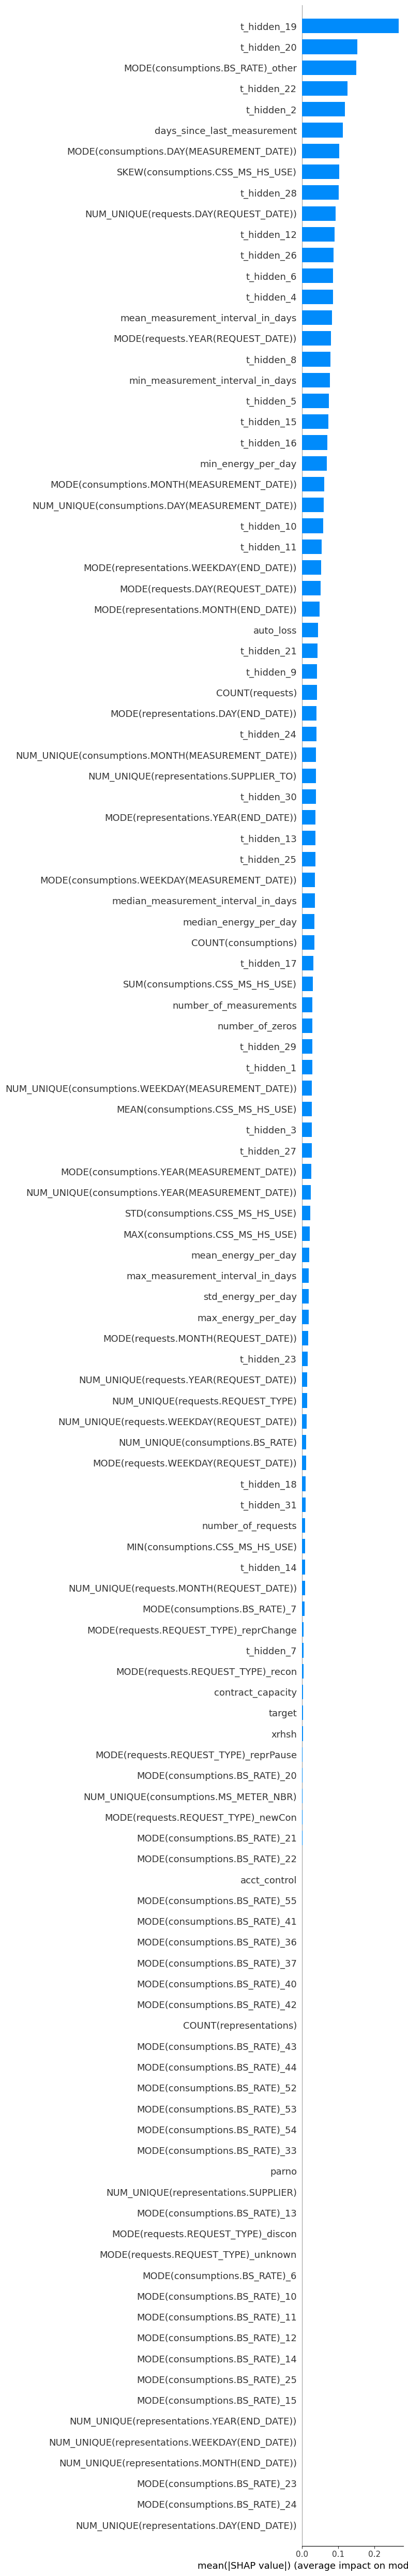

In [9]:
X = df.drop(['target'], axis=1)
y = df['target']
train(clf, X, y, list(df.columns))